
<h1><center>Pyspark</center></h1>

In [1]:
# Basic Imports # 

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from operator import add
import random, warnings, sys, time
from __future__ import print_function
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime, tzinfo, timedelta

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
rdd = sc.textFile("$PATH/meetup.csv")

<br>
### Another way to create an rdd


In [4]:
rdd1 = sc.parallelize([1,2,3,4,5,6,7,8,9,10])


### Sum the squares of the integers from 1 to 10.

In [5]:
rdd1.map(lambda x: x**2).sum()

385

<br>
### Display all the elements in the rdd using collect()
Not a good choice if you have huge dataset

In [6]:
rdd1.collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### `take(n)`
Instead use take which gives you n elements

In [7]:
rdd.take(1)

['eventid,groupurlname,grouplon,venue.name,groupcity,eventtime,title,eventname,venue.lon,id,visibility,groupid,rsvp_id,groupname,grouplat,_version_,response,venueid,guests,groupstate,venue.lat,groupcountry,membername,memberid']

### Counting the number of elements in the file

In [8]:
rdd.count()

10000

RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. 
We just performed atwo action on the **`rdd`** i.e **count** and **collect**

## Transformations 

### `map`

In [9]:
map_rdd = rdd.map(lambda l:l.split(",")).map(lambda l:(l,l[19]))
map_rdd.take(1)

[(['eventid',
   'groupurlname',
   'grouplon',
   'venue.name',
   'groupcity',
   'eventtime',
   'title',
   'eventname',
   'venue.lon',
   'id',
   'visibility',
   'groupid',
   'rsvp_id',
   'groupname',
   'grouplat',
   '_version_',
   'response',
   'venueid',
   'guests',
   'groupstate',
   'venue.lat',
   'groupcountry',
   'membername',
   'memberid'],
  'groupstate')]

### `flatMap`

In [10]:
flatmap_rdd = rdd.flatMap(lambda l:l.split(","))
flatmap_rdd.take(15)

['eventid',
 'groupurlname',
 'grouplon',
 'venue.name',
 'groupcity',
 'eventtime',
 'title',
 'eventname',
 'venue.lon',
 'id',
 'visibility',
 'groupid',
 'rsvp_id',
 'groupname',
 'grouplat']

### `filter`

In [11]:
filter_rdd = flatmap_rdd.filter(lambda l: l == "CA")
filter_rdd.count()

1852

### `reduceBykey`

In [12]:
from operator import add
add_func =flatmap_rdd.map(lambda word: (word,1)).reduceByKey(add)
add_func.take(2)

[('eventid', 1), ('grouplon', 1)]

### WordCount

In [13]:
counts = flatmap_rdd.flatMap(lambda x:x.split(" "))\
        .map(lambda x: (x,1))\
        .reduceByKey(lambda x,y: x+y)

In [14]:
counts.take(5)

[('eventid', 1),
 ('grouplon', 1),
 ('venue.name', 1),
 ('groupcity', 1),
 ('eventtime', 1)]

### `sortByKey( ascending=True|False )`

In [15]:
counts.sortByKey(ascending=False).take(5)

[('🥗🍸Picnic', 1), ('🙏🏽"', 2), ('😋', 1), ('🔺', 5), ('🔷', 2)]

In [16]:
counts.sortBy(lambda value: value[1], ascending=False).take(5)

[('', 13185), ('public', 10016), ('us', 9266), ('0', 9249), ('yes', 7732)]

<br>
### Pi Calculation

In [17]:
%%time
import random

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

count = sc.parallelize(range(0, 10000000)) \
             .filter(inside).count()
print("Pi is roughly %f" % (4.0 * count / 10000000))

Pi is roughly 3.142291
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.19 s


# Actions

### `countByKey`

In [43]:
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 1)])
sorted(rdd.countByKey().items())

[('a', 2), ('b', 1)]

### `first()`

In [19]:
counts.first()

('eventid', 1)

### `takeOrdered(n, [ordering])`

In [20]:
counts.takeOrdered(5)

[('', 13185), ('!', 16), ('!!', 9), ('!!!', 6), ('!!!!', 1)]

### `top(n)`

In [21]:
counts.top(5)

[('🥗🍸Picnic', 1), ('🙏🏽"', 2), ('😋', 1), ('🔺', 5), ('🔷', 2)]

### `saveAsTextFile(path)`

In [22]:
counts.saveAsTextFile("$PATH/SampleTextOutput")

### `saveAsSequenceFile(path)`

In [23]:
counts.saveAsSequenceFile("$PATH/SampleSequenceOutput")

<br>
<br>

## DataFrames 

### Read the CSV File

In [24]:
df = spark.read.csv('$PATH/meetup.csv',header=True,inferSchema=True)

In [25]:
df = df.withColumn('date', df['eventtime'].cast('date'))

### `printSchema`

In [26]:
df.printSchema()

root
 |-- eventid: string (nullable = true)
 |-- groupurlname: string (nullable = true)
 |-- grouplon: double (nullable = true)
 |-- venue.name: string (nullable = true)
 |-- groupcity: string (nullable = true)
 |-- eventtime: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- eventname: string (nullable = true)
 |-- venue.lon: string (nullable = true)
 |-- id: string (nullable = true)
 |-- visibility: string (nullable = true)
 |-- groupid: string (nullable = true)
 |-- rsvp_id: string (nullable = true)
 |-- groupname: string (nullable = true)
 |-- grouplat: string (nullable = true)
 |-- _version_: string (nullable = true)
 |-- response: string (nullable = true)
 |-- venueid: string (nullable = true)
 |-- guests: string (nullable = true)
 |-- groupstate: string (nullable = true)
 |-- venue.lat: string (nullable = true)
 |-- groupcountry: string (nullable = true)
 |-- membername: string (nullable = true)
 |-- memberid: string (nullable = true)
 |-- date: date (nullabl

<br>
### `show()` - Display the dataframe 

In [27]:
df.show()

+------------+--------------------+--------+--------------------+------------------+-------------------+-----+--------------------+-----------+--------------------+----------+--------+----------+--------------------+---------+-------------------+-------------------+--------+--------+----------+---------+------------+-------------------+-------------+----------+
|     eventid|        groupurlname|grouplon|          venue.name|         groupcity|          eventtime|title|           eventname|  venue.lon|                  id|visibility| groupid|   rsvp_id|           groupname| grouplat|          _version_|           response| venueid|  guests|groupstate|venue.lat|groupcountry|         membername|     memberid|      date|
+------------+--------------------+--------+--------------------+------------------+-------------------+-----+--------------------+-----------+--------------------+----------+--------+----------+--------------------+---------+-------------------+-------------------+------

<br>
### Most Frequent Events

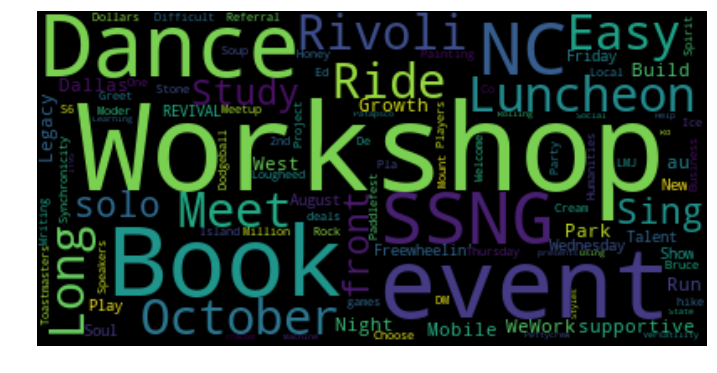

In [36]:
! pip install wordcloud
import matplotlib.pyplot as plt
word_cloud = df.filter(df.eventname != 'None').select("eventname")

word_cloud_pandas = word_cloud.toPandas()
plt.rcParams['figure.figsize']=(12.0,15.0)    
plt.rcParams['font.size']=12                 
plt.rcParams['savefig.dpi']=100              
plt.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=100,
                          random_state=4
                         ).generate(str(word_cloud_pandas['eventname']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

<br>

### Most Responses per state

In [29]:
most_responses = df.filter(df.groupstate != 'null').groupby("groupstate").agg({"response":"count"})\
.orderBy("count(response)",ascending=False)
most_responses.show()

+----------+---------------+
|groupstate|count(response)|
+----------+---------------+
|        CA|           1847|
|        NY|            908|
|        TX|            620|
|        FL|            550|
|        CO|            477|
|        ON|            437|
|        IL|            374|
|        PA|            350|
|        NC|            331|
|        GA|            323|
|        VA|            301|
|        MA|            265|
|        WA|            257|
|        DC|            247|
|        OR|            227|
|        AZ|            216|
|        OH|            210|
|        NJ|            189|
|        BC|            174|
|        MN|            151|
+----------+---------------+
only showing top 20 rows



<br>
<br>

### Most Responses per City

In [30]:
resp_city = df.groupby(["groupcity","memberid"]).\
            count().orderBy("count",ascending=False)

resp_city.show()

+------------+---------+-----+
|   groupcity| memberid|count|
+------------+---------+-----+
|     Atlanta|  9014062|   43|
|    New York|  8516444|   26|
| Morrisville|189073790|   22|
|     Toronto|  4824584|   14|
|     Raleigh| 84713982|   14|
|  Sacramento|139633032|   14|
|      Novato| 59754472|   13|
|   Las Vegas| 63187852|   12|
|    New York| 56359272|   12|
|   San Diego| 12634468|   11|
|      Durham|137080172|   11|
|     Toronto|105554052|    9|
|    San Jose| 66798272|    9|
|    Columbus| 11098921|    9|
|   San Diego|    31551|    8|
|Auburn Hills|232003294|    8|
|  Mount Dora| 74618122|    8|
|      Denver| 57059682|    8|
|     Raleigh|233524541|    8|
|       Media|230518046|    8|
+------------+---------+-----+
only showing top 20 rows



<br>
<br>
<br>

### Yes vs No

In [40]:
yes_response = df.groupby(df['eventname'],df['response']).count().orderBy("count",ascending=False)
yes = yes_response.filter(yes_response.response == 'yes').count()
no_response = df.groupby(df['eventname'],df['response']).count().orderBy("count",ascending=False)
no = no_response.filter(no_response.response == 'no').count()

print("Yes Count: ",yes,"\n","No Count:",no)

Yes Count:  4150 
 No Count: 1877


<br>
<br>
<br>

### Most Number of Events 

In [32]:
df.createOrReplaceTempView("satori")
event_states = spark.sql("select eventname,count(*) from satori  \
where groupstate is not null group by eventname  order by count(1) desc")
event_states.show()

+--------------------+--------+
|           eventname|count(1)|
+--------------------+--------+
| Business Networking|      45|
|Monday Dinner and...|      31|
|LAToken Blockchai...|      29|
|Join us for our F...|      25|
|The North Pennsme...|      24|
|   Super Meetup 2017|      22|
|Using Machine Lea...|      21|
|We're Not Dead ye...|      20|
|The Dancer's Work...|      20|
|Scaling Deep Lear...|      20|
|Labor Day weekend...|      20|
|Let's Discuss: Ho...|      19|
|          Happy Hour|      18|
|Ready to Resist c...|      17|
|APIs + GraphQL + ...|      17|
|    Object Detection|      16|
|Board Games for G...|      16|
|Pickup Soccer at ...|      16|
|MOROCCO: Marrakes...|      16|
|🇫🇷 🍷🍫French M...|      15|
+--------------------+--------+
only showing top 20 rows



<br>
<br>
<br>

### Number of memebers who attended the meetup

In [33]:

res = df.filter(df.groupstate != 'None').groupby(["groupstate","memberid"]).count().orderBy("count",ascending=False)
res.show()

+----------+---------+-----+
|groupstate| memberid|count|
+----------+---------+-----+
|        GA|  9014062|   43|
|        NY|  8516444|   26|
|        PA|189073790|   22|
|        FL|  2889550|   16|
|        CA|139633032|   14|
|        ON|  4824584|   14|
|        NC| 84713982|   14|
|        CA| 59754472|   13|
|        ON|105554052|   13|
|        FL|224134430|   13|
|        NY| 56359272|   12|
|        NV| 63187852|   12|
|        NC|137080172|   11|
|        CA| 12634468|   11|
|        CO| 57059682|    9|
|        CA|    31551|    9|
|        CA| 66798272|    9|
|        OH| 11098921|    9|
|        PA|230518046|    8|
|        MI|232003294|    8|
+----------+---------+-----+
only showing top 20 rows



### RDBMS

In [41]:
jdbc_tblemployees = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/dbo") \
    .option("dbtable", "tblemployees") \
    .option("user", "username") \
    .option("password", "password") \
    .option("driver","com.mysql.jdbc.Driver") \
    .load()

In [ ]:
jdbc_tblemployees.printSchema()

In [ ]:
jdbc_tblpayemployeeparamdetails = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/dbo") \
    .option("dbtable", "tblpayemployeeparamdetails") \
    .option("user", "username") \
    .option("password", "password") \
    .option("driver","com.mysql.jdbc.Driver") \
    .load()

In [ ]:
jdbc_tblpayemployeeparamdetails.printSchema()

In [ ]:
joined_df = jdbc_tblemployees.join(jdbc_tblpayemployeeparamdetails,\
                                   jdbc_tblemployees['EmployeeNumber'] == jdbc_tblpayemployeeparamdetails['EmployeeNumber'],"inner").\
                                   drop(jdbc_tblemployees['EmployeeNumber'])
joined_df.count()

In [ ]:
outer_join = jdbc_tblpayemployeeparamdetails.join(jdbc_tblemployees, jdbc_tblemployees['EmployeeNumber'] == jdbc_tblpayemployeeparamdetails['EmployeeNumber'],'leftsemi').\
             drop(jdbc_tblemployees['Employeenumber'])
outer_join.count()

In [ ]:
average_sal = joined_df.groupBy("DepartmentCode").agg({'Amount':"mean"}).orderBy("avg(Amount)",ascending=False).show()

In [ ]:
average_sal = outer_join.groupby("EmployeeNumber").agg({'Amount':"mean"}).orderBy("avg(Amount)",ascending=False).show()
average_sal

In [ ]:
joined_df.createOrReplaceTempView("table")

In [ ]:
spark.sql("select EmployeeNumber, avg(Amount) as avg from table group by EmployeeNumber,Amount order by avg desc ").show()

In [ ]:
spark.sql("select LocationType, Sex, count(*) as count from table where Sex is not null group by LocationType,Sex order by count desc").show()

In [ ]:
ssc = StreamingContext(sc, 1)

In [ ]:
lines = ssc.textFileStream("$PATH/README.md")
counts = lines.flatMap(lambda line: line.split(" "))\
                  .map(lambda x: (x, 1))\
                  .reduceByKey(lambda a, b: a+b)
counts.pprint()
counts.saveAsTextFiles("$PATH/output.txt")
ssc.start()
ssc.awaitTermination(10)
ssc.stop()

In [ ]:
ssc.stop()